In [4]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import nltk
from nltk.corpus import gutenberg
#nltk.download('gutenberg')
#nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


# tfidf in sklearn

Happily for us, sklearn has a tfidf function that will do all our heavy lifting.  It also has a [very long list of stop words](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).  Since we're going to be doing dimension reduction later on anyway, let's keep all the words for now.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


# Dimension reduction
Okay, now we have our vectors, with one vector per paragraph.  It's time to do some dimension reduction.  We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity):

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.22493562555018
Component 0:
" Oh !     0.999292
" Oh !"    0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !"    0.999292
" Oh !     0.999292
" Oh !     0.999292
" Oh !     0.999292
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633950
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.590473
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.564248
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

From gazing at the most representative sample paragraphs, it appears that component 0 targets the exclamation 'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions by or directly related to Emma.

What fun! 

# Sentence similarity

We can also look at how similar various sentences are to one another.  For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set:


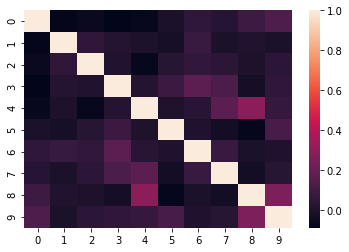

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [8]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


Not much similarity at all except between sentences 8 and 9, both of which seem to describe people getting along well.

# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4? 

In [10]:
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!

X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh no !      0.999921
" Oh !         0.999921
" Oh !         0.999921
" Me ! oh !    0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh !         0.999921
" Oh !"        0.999921
" Oh !         0.999921
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.619686
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                                              

Component 0 is similar

Component 1 is different

Component 2 is different

Component 3 is different

Component 4 is different

# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers.  There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well.  We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities.  Change things up a few times and see how that affects the results of the LSA.  Write up your observations and share them with your mentor.

## Change max_df, min_df:

In [11]:
vectorizer = TfidfVectorizer(max_df=0.30, # drop words that occur in more than 30% of the paragraphs
                             min_df=3, # only use words that appear at least 3 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

Number of features: 1358


In [12]:
# Keep same number of components
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Fit with train data
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !     0.999241
" Oh !     0.999241
" Oh !     0.999241
" Oh !     0.999241
" Oh !"    0.999241
" Oh !     0.999241
" Oh !     0.999241
" Oh !     0.999241
" Oh !"    0.999241
" Oh !     0.999241
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.675074
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.594776
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.586274
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.576293
" Emma ," said Mr . Knight

In [13]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !"        0.999915
" Oh !         0.999915
" Oh !         0.999915
" Oh no !      0.999915
" Me ! oh !    0.999915
" Oh !         0.999915
" Oh !         0.999915
" Oh !         0.999915
" Oh !         0.999915
" Oh !         0.999915
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.612814
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                                              

## Change number of SVC components:

In [14]:
# Reduce to 50 components
svd= TruncatedSVD(50)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !     0.999327
" Oh !"    0.999327
" Oh !     0.999327
" Oh !     0.999327
" Oh !     0.999327
" Oh !     0.999327
" Oh !     0.999327
" Oh !"    0.999327
" Oh !     0.999327
" Oh !     0.999327
Name: 0, dtype: float64
Component 1:
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [15]:
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !       0.999951
" Oh !       0.999951
" Oh !       0.999951
" Oh !       0.999951
" Oh !       0.999951
" Oh !       0.999951
" Oh !       0.999951
" Oh no !    0.999951
" Oh !       0.999951
" Oh no !    0.999951
Name: 0, dtype: float64
Component 1:
Emma would not have smiled for the world , and only said , " Is Mr . Elton gone on foot to Donwell ? He will have a hot walk ."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Findings Summary:

**Original - train**

0 - Oh!

1 - you have made her too tall

2 - chapters 

3 - Ah!

4 - There were misunderstandings between them

**Original - test**

0 - Oh!

1 - Well Mrs. Weston

2 - Ah!

3 - Mr., After tea

4 - Yes, sometimes he can

**Change max/min - train**

0 - Oh!

1 - You have made 

2 - chapters

3 - There were misunderstandings

4 - Ah!

**Change max/min - test** 

0 - Oh!

1 - Well, Mrs. Weston

2 - Ah!

3 - Emma, My Emma!

4 - Yes I should I am sure I should

**Change Number of SVC components - train**

0 - Oh!

1 - You get upon

2 - Chapters

3 - There were misunderstandings

4 - Ah!

**Change Number of SVC components - test**

0 - Oh!

1 - Emma would not have smiled for the world

2 - Ah!

3 - Emma had done

4 - Yes I should I am sure I should